# Project 101 – Model Explainability

This notebook focuses on interpreting the baseline machine learning model
using explainability techniques.

The goal is to understand *why* the model makes certain predictions,
identify potential risks, and build trust in the model's decisions.

---

## Explainability Strategy

This project is built with an explainability-first mindset.

The goal of this notebook is to understand *why* the baseline model makes its
predictions, not just whether it performs well.

### What we explain
- **Global behavior**: Which features generally influence the model the most.
- **Local decisions**: Why the model predicted Up/Down for a specific day.
- **Error cases**: How feature contributions differ in wrong predictions.

### Why SHAP
We use SHAP because it provides feature-level contributions that are:
- Consistent and comparable across samples
- Suitable for tree-based models (Random Forest)
- Easy to communicate to non-technical stakeholders

### Output of this notebook
- Global feature importance summary
- Local explanations for selected examples
- A short list of insights and risks discovered through explanations


## 1. Load Trained Model and Data

## 2. Why Explainability Matters

Machine learning models can produce accurate predictions, but accuracy alone is
not enough in real-world decision-making.

In this project, explainability is important for three reasons:

### 1) Trust & Transparency
A prediction like "Up" or "Down" is not useful unless we can explain *why*
the model made that decision. Explainability helps stakeholders understand
the drivers behind a prediction.

**Example:**  
If the model predicts an upward movement, we want to know whether it was driven by
recent momentum (returns), trend signals (moving averages), or changes in market
participation (volume).

### 2) Risk Awareness (Confident but Wrong)
Models can be confidently wrong. Explainability helps identify cases where the model
relies on misleading patterns or unstable signals.

**Example:**  
A high short-term return might suggest a rise, but if volatility is extremely high,
the prediction may be risky and less reliable.

### 3) Better Model Improvement
Explainability shows which features are influencing the model and helps guide
future feature engineering and model improvements in a structured way.

**Example:**  
If the model relies heavily on one feature, we may add complementary features,
reduce noise, or adjust the modeling approach to improve robustness.

---

**Goal of this notebook:**  
Use SHAP to explain the baseline Random Forest model both globally (overall behavior)
and locally (individual predictions), and then summarize insights that can be used
in the README and future iterations of the project.


## Notebook Outline
1. Load the model and data
2. Prepare X and y using the exact training columns
3. Time-based split + index reset (best practice)
4. SHAP: Global explanation
5. SHAP: Local explanation (single prediction)
6. Error analysis with SHAP
7. Key insights


## 1) Load Trained Model and Data

In [1]:
# ==============================
# Imports
# ==============================
import pandas as pd
import numpy as np
import joblib
import shap

shap.initjs()


In [2]:
# ==============================
# Load feature dataset + trained model
# ==============================
features_path = "../data/processed/stock_features_v1.csv"
model_path = "../models/rf_baseline_v1.pkl"

df = pd.read_csv(features_path)
rf = joblib.load(model_path)

df.head()


,Date,Price,Open,High,Low,Vol.,Change %,return_1d,return_lag_1,return_lag_3,return_lag_5,ma_5,ma_10,ma_20,volatility_5,volatility_10,volume_change,target
0,2000-01-31,6.41,6.41,6.41,6.41,20140000.0,-1.69,-0.016871,-0.016591,0.000000,-0.007474,6.568,6.639,6.6670,0.008911,0.006939,1.218062,1
1,2000-02-01,6.52,6.52,6.52,6.52,6340000.0,1.72,0.017161,-0.016871,-0.001506,0.000000,6.544,6.615,6.6595,0.014082,0.009663,-0.685204,1
2,2000-02-02,6.54,6.54,6.54,6.54,9010000.0,0.31,0.003067,0.017161,-0.016591,0.000000,6.524,6.596,6.6530,0.014341,0.009877,0.421136,0
3,2000-02-03,6.53,6.53,6.53,6.53,2410000.0,-0.15,-0.001529,0.003067,-0.016871,-0.001506,6.504,6.576,6.6460,0.014340,0.009840,-0.732519,1
4,2000-02-05,6.55,6.55,6.55,6.55,10110000.0,0.31,0.003063,-0.001529,0.017161,-0.016591,6.510,6.562,6.6400,0.012201,0.009949,3.195021,1


## 2) Prepare Features (X) and Target (y)
We ensure that **X uses the exact same feature columns** used during training to avoid feature mismatch issues (e.g., accidentally including `target` or `date`).


In [3]:
# Use the exact feature columns used during training (most robust approach)
y = df["target"].copy()

# rf.feature_names_in_ (scikit-learn >=1.0) ensures the feature columns match training exactly
X = df[rf.feature_names_in_].copy()

X.shape, y.shape


((4981, 16), (4981,))

## 3) Time-based Split + Index Reset (Best Practice)
We use a chronological split (80/20) to avoid leakage. We then reset indices so that pandas row positions align with NumPy/SHAP arrays.


In [4]:
split_index = int(len(df) * 0.8)

X_test = X.iloc[split_index:].copy()
y_test = y.iloc[split_index:].copy()

# Reset indices to keep alignment between pandas rows and SHAP/NumPy arrays
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_test.shape, y_test.shape


((997, 16), (997,))

## 4) SHAP – Global Explanation
We aim to determine: *in general*, which characteristics exert the greatest influence on the model's decisions across the test data?

In [5]:
# Create SHAP explainer for the trained Random Forest
explainer = shap.TreeExplainer(rf)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Inspect shape (varies by SHAP version)
sv = np.array(shap_values)
sv.shape


(997, 16, 2)

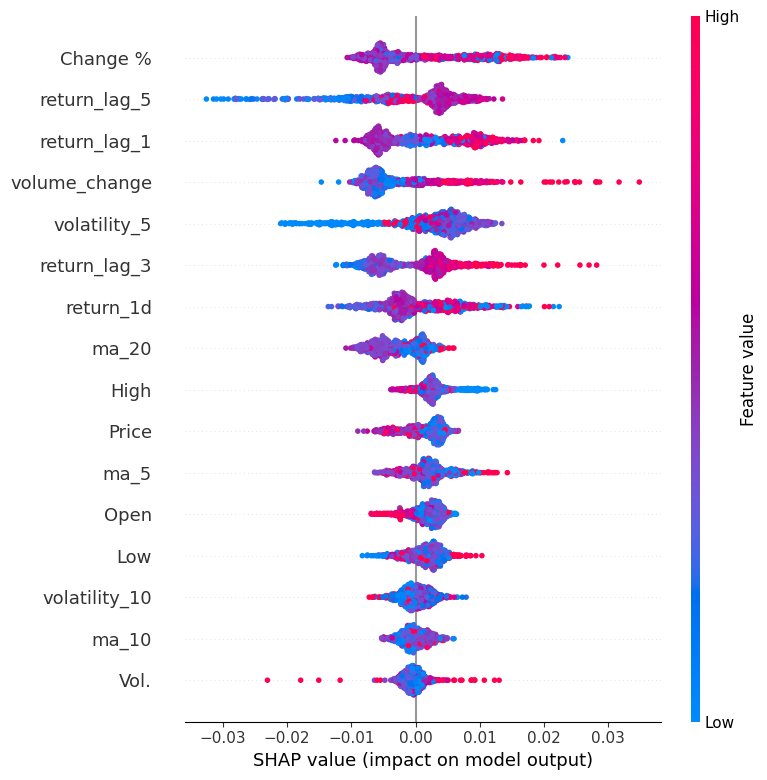

In [ ]:
# Global summary plot
# Case A: sv is (n_samples, n_features)  -> directly plot
# Case B: sv is (n_samples, n_features, n_classes) -> choose a class (e.g., class 0 or 1)
sv = np.array(shap_values)

if sv.ndim == 2:
    shap.summary_plot(sv, X_test)
elif sv.ndim == 3:
    # Select the category to be summarized:
    # 0 = Down, 1 = Up (typically)
    class_id = 1  # summary for "Up" by default
    shap.summary_plot(sv[:, :, class_id], X_test)
else:
    raise ValueError(f"Unexpected SHAP values shape: {sv.shape}")


## 5) SHAP – Local Explanation (Single Prediction)
Here, we explain a single decision (one row) in detail: Why did the model predict Down/Up for this specific day?

In [7]:
# Pick one example from the test set
i = 0  # change this index to inspect a different sample
X_one = X_test.iloc[[i]]

pred_class = rf.predict(X_one)[0]
pred_prob = rf.predict_proba(X_one)[0]

pred_class, pred_prob, rf.classes_


(np.int64(0), array([0.58515219, 0.41484781]), array([0, 1]))

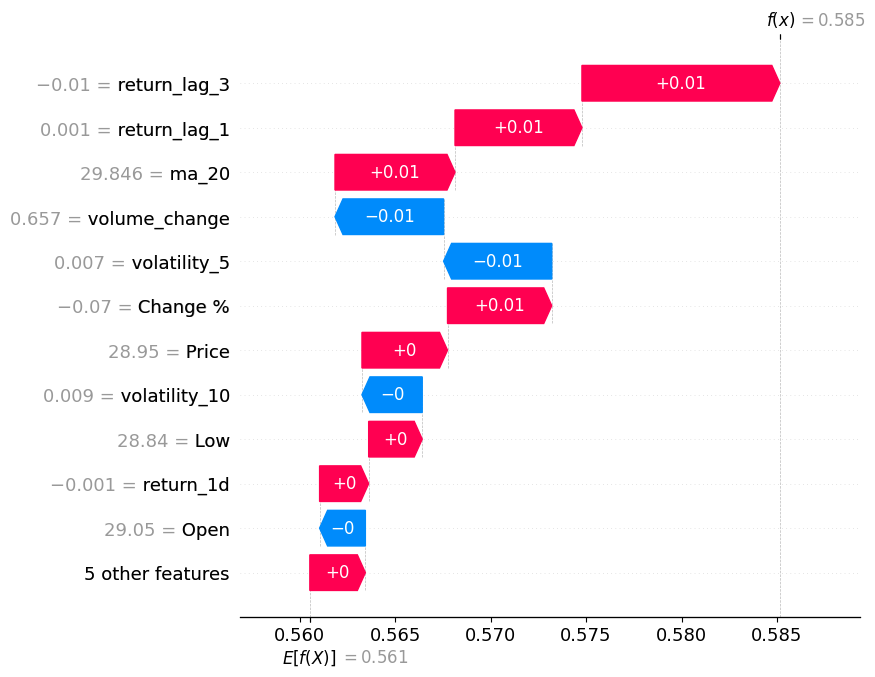

In [8]:
# Waterfall plot for the predicted class (robust for binary classification)
sv = np.array(shap_values)

if sv.ndim == 2:
    shap_one = sv[i, :]
    base_val = explainer.expected_value if not isinstance(explainer.expected_value, (list, np.ndarray)) else float(np.array(explainer.expected_value).mean())
else:
    # sv: (n_samples, n_features, n_classes)
    shap_one = sv[i, :, int(pred_class)]
    base_val = explainer.expected_value[int(pred_class)]

exp = shap.Explanation(
    values=shap_one,
    base_values=base_val,
    data=X_test.iloc[i].values,
    feature_names=X_test.columns
)

shap.plots.waterfall(exp, max_display=12)


## 6) Error Analysis Through Explainability
We identify the erroneous cases, then interpret a misclassified example using SHAP to understand the underlying cause of the error.

In [9]:
# Identify misclassified samples
y_pred_test = rf.predict(X_test)
mis_idx = np.where(y_pred_test != y_test.values)[0]

len(mis_idx), mis_idx[:10]


(507, array([ 2,  7,  8,  9, 11, 16, 20, 21, 22, 24]))

true: 1 | pred: 0


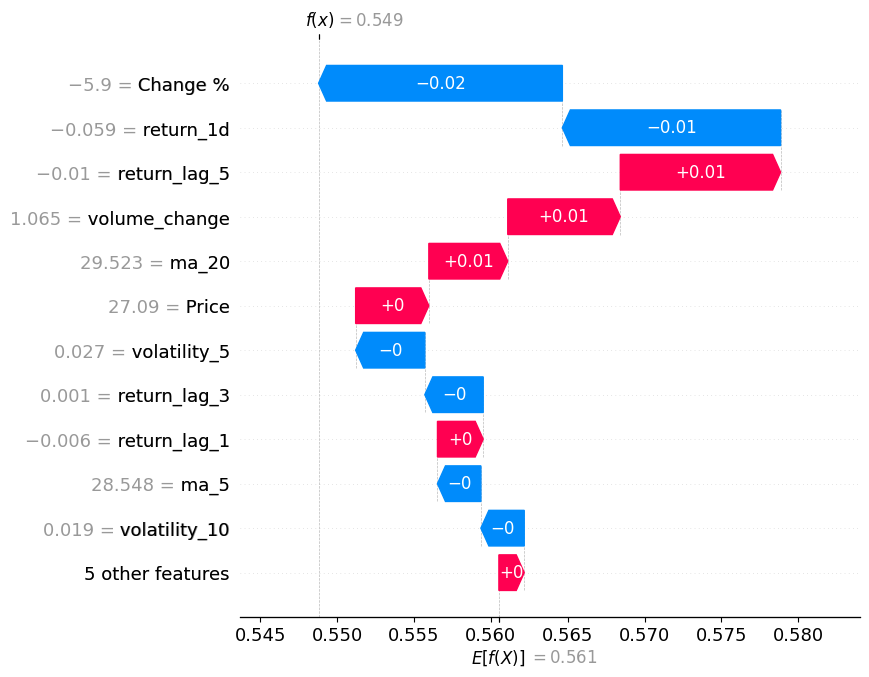

In [10]:
# Explain the first misclassified sample (if any)
if len(mis_idx) == 0:
    print("No misclassified samples found in the test split (great!).")
else:
    k = int(mis_idx[0])

    true_k = int(y_test.iloc[k])
    pred_k = int(y_pred_test[k])

    print("true:", true_k, "| pred:", pred_k)

    sv = np.array(shap_values)

    if sv.ndim == 2:
        shap_err = sv[k, :]
        base_err = explainer.expected_value if not isinstance(explainer.expected_value, (list, np.ndarray)) else float(np.array(explainer.expected_value).mean())
    else:
        shap_err = sv[k, :, pred_k]
        base_err = explainer.expected_value[pred_k]

    exp_err = shap.Explanation(
        values=shap_err,
        base_values=base_err,
        data=X_test.iloc[k].values,
        feature_names=X_test.columns
    )

    shap.plots.waterfall(exp_err, max_display=12)


## 7) Key Insights (fill after running plots)
- What are the top 3 globally influential features?
- In the local explanation: what pushed the decision?
- In the misclassified case: which signals misled the model?
